<a href="https://colab.research.google.com/github/dpnolan/BPE/blob/main/BPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Financial Time Series for Cointegration

Peter Nolan [databeaker@gmail.com](mailto:databeaker@gmail.com)

##Import packages and connect to data file on Google Drive

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!python --version
print("np.__version__",np.__version__)
print("pd.__version__",pd.__version__)

Python 3.7.10
np.__version__ 1.19.5
pd.__version__ 1.1.5


##Access data, check and calculate summary statistics


This is the two years of data for BP equity and AT1 (=?) supplied by Stuart

In [145]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bpe.csv',index_col='Date',parse_dates=True)

In [147]:
df.describe()

,Equity,Bond
count,517.000000,517.000000
mean,2.425087,106.636818
std,1.157521,6.878643
min,0.771000,86.161000
25%,1.208000,101.565000
50%,2.223800,105.128000
75%,3.504700,112.351000
max,4.349800,118.086000


In [148]:
df.head()

,Equity,Bond
Date,,
2015-02-02,3.3675,116.164
2015-02-03,3.4841,116.830
2015-02-04,3.4034,116.673
2015-02-05,3.3603,116.088
2015-02-06,3.3765,117.118


In [149]:
df.index[0]

Timestamp('2015-02-02 00:00:00')

Plot both raw price series
Neither of these time series look stationary

[]

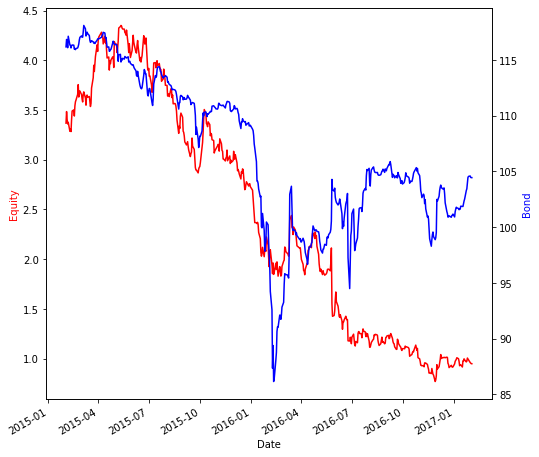

In [150]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(8,8))

# Text in the x axis will be displayed in 'YYYY-mm' format.

#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%q'))

ax1.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.set_ylabel('Equity',color='red')
ax1.plot(df['Equity'],color='red')
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-m'))


#Duplicate the axis
ax2 = ax1.twinx()

ax2.set_ylabel('Bond', color='blue')  # we already handled the x-label with ax1
ax2.plot(df['Bond'],color='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.plot()

##Correlation between the two series

Autocorrelation is very high for both series

In [151]:
print('Autocorrelation for Equity is {:.4%}'.format(df['Equity'].autocorr()))
print('Autocorrelation for Bond is {:.4%}'.format(df['Bond'].autocorr()))

Autocorrelation for Equity is 99.8330%
Autocorrelation for Bond is 99.4078%


Correlation between the two raw data time series is high

In [152]:
raw_correlation=df['Bond'].corr(df['Equity'])
print("Raw correlation = {:.3%}".format(raw_correlation))

Raw correlation = 79.069%


However, applying a time window to the correlation shows it is quite unstable

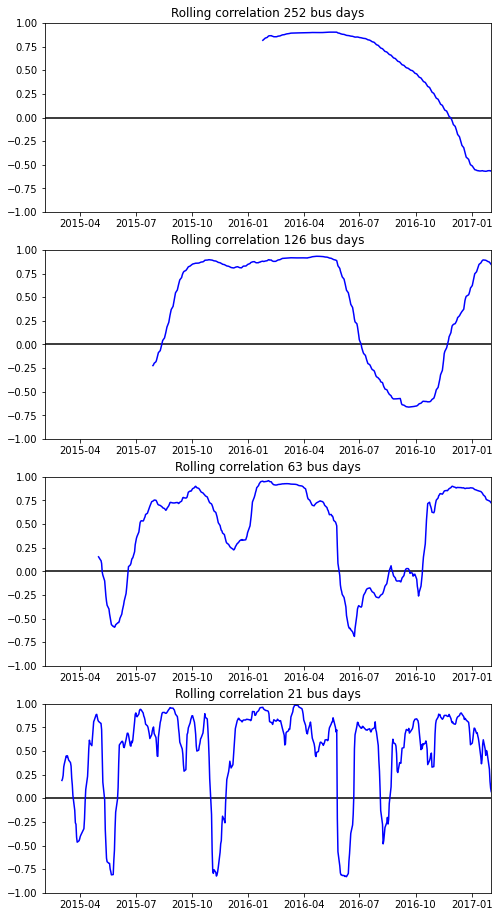

In [168]:
fig, axs = plt.subplots(4, 1, figsize=(8,16))
increments=[252,126,63,21]

for n, ax in enumerate(axs):
    rolling_correlation=df['Equity'].rolling(increments[n]).corr(df['Bond'])
    axs[n].set_xlim(df.index[0],df.index[-1])
    axs[n].axhline(0, color='k')
    axs[n].set_ylim(-1,1)
    axs[n].plot(rolling_correlation,color='b')
    axs[n].set_title('Rolling correlation {:g} bus days'.format(increments[n]) )


Text(0.5, 1.0, 'Rolling 1 yr correlation')

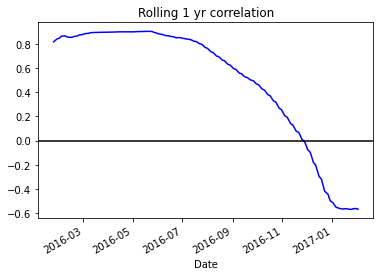

In [154]:
rolling_correlation=df['Equity'].rolling(252).corr(df['Bond'])
rolling_correlation.plot(color='b')
plt.axhline(0, color='k')
plt.title('Rolling 1 yr correlation')

Text(0.5, 1.0, 'Rolling 6m correlation')

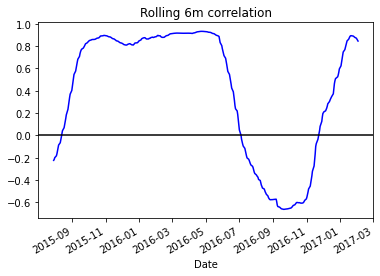

In [155]:
rolling_correlation=df['Equity'].rolling(126).corr(df['Bond'])
rolling_correlation.plot(color='b')
plt.axhline(0, color='k')
plt.title('Rolling 6m correlation')

Text(0.5, 1.0, 'Rolling 3m correlation')

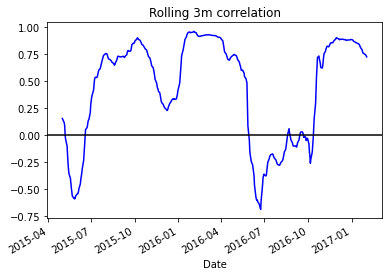

In [156]:
rolling_correlation=df['Equity'].rolling(63).corr(df['Bond'])
rolling_correlation.plot(color='b')
plt.axhline(0, color='k')
plt.title('Rolling 3m correlation')

Text(0.5, 1.0, 'Rolling 1m correlation')

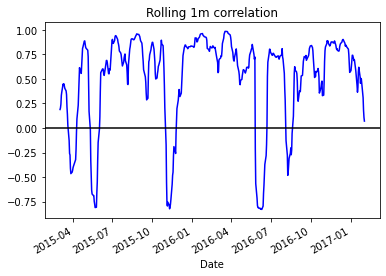

In [157]:
rolling_correlation=df['Equity'].rolling(21).corr(df['Bond'])
rolling_correlation.plot(color='b')
plt.axhline(0, color='k')
plt.title('Rolling 1m correlation')

##Analyse 1 day percentage returns for both series

In [158]:
df['Equity 1d Return'] = df['Equity'].pct_change()
df['Bond 1d Return'] = df['Bond'].pct_change()

In [159]:
df.describe()

,Equity,Bond,Equity 1d Return,Bond 1d Return
count,517.000000,517.000000,516.000000,516.000000
mean,2.425087,106.636818,-0.001963,-0.000178
std,1.157521,6.878643,0.030756,0.007539
min,0.771000,86.161000,-0.264834,-0.056532
25%,1.208000,101.565000,-0.018563,-0.002023
50%,2.223800,105.128000,-0.002066,-0.000059
75%,3.504700,112.351000,0.011974,0.001883
max,4.349800,118.086000,0.136638,0.054082


By inspection, these two new time series look more stationary, at least for most of the time 

[]

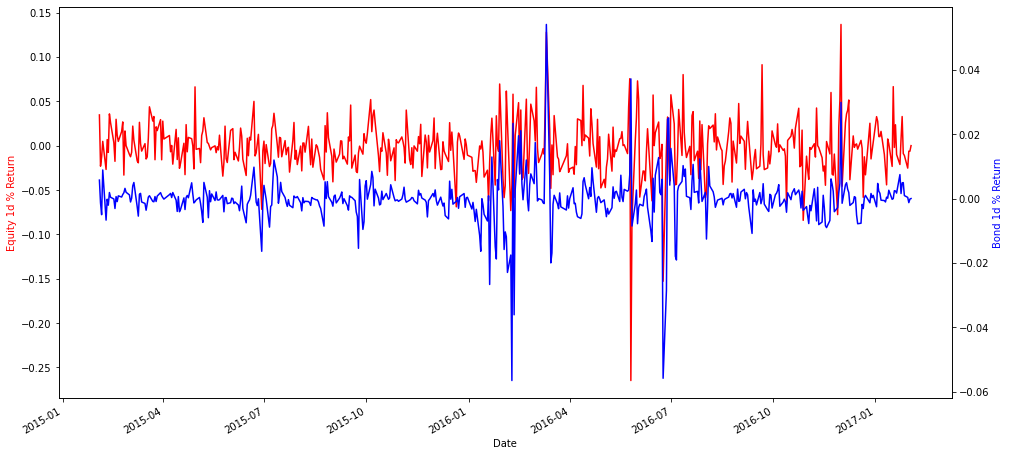

In [164]:
fig, ax1 = plt.subplots(figsize=(16,8))

ax1.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.set_ylabel('Equity 1d % Return',color='red')
ax1.plot(df['Equity 1d Return'],color='red')
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-m'))


#Duplicate the axis
ax2 = ax1.twinx()

ax2.set_ylabel('Bond 1d % Return', color='blue')  # we already handled the x-label with ax1
ax2.plot(df['Bond 1d Return'],color='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.plot()

Correlation of 1d returns is lower than for absolute levels

In [165]:
raw_1d_return_correlation=df['Bond 1d Return'].corr(df['Equity 1d Return'])
print("Raw 1d return correlation = {:.3%}".format(raw_1d_return_correlation))

Raw 1d return correlation = 38.499%


Looking at the rolling window correlation for the 1d returns

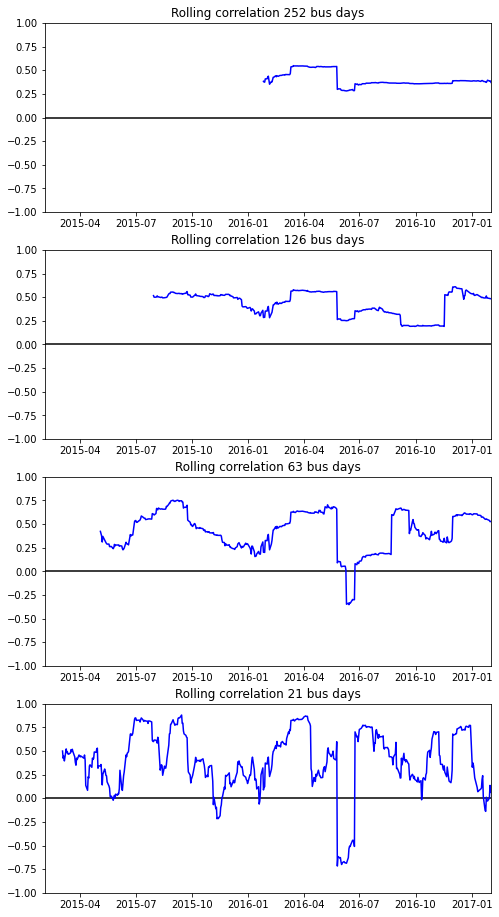

In [167]:
fig, axs = plt.subplots(4, 1, figsize=(8,16))
increments=[252,126,63,21]

for n, ax in enumerate(axs):
    rolling_correlation=df['Equity 1d Return'].rolling(increments[n]).corr(df['Bond 1d Return'])
    axs[n].set_xlim(df.index[0],df.index[-1])
    axs[n].set_ylim(-1,1)
    axs[n].axhline(0, color='k')
    axs[n].plot(rolling_correlation,color='b')
    axs[n].set_title('Rolling correlation {:g} bus days'.format(increments[n]) )
